<a href="https://colab.research.google.com/github/jshogland/SpatialModelingTutorials/blob/main/Notebooks/glcm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing one pass gray level co-occurrence matrix (GLCM) for any bit depth, without using a co-occurrence probability matrix.
This notebook documents how to calculate GLCM metrics using an alterative, one pass processing technique. This technique does not require specifying bit depth, bypasses creating a co-occurrence matrix, allows for implementation within a moving windows context, and is adapted to work within the Raster Tools processing architecture.

by John Hogland 2/6/2025

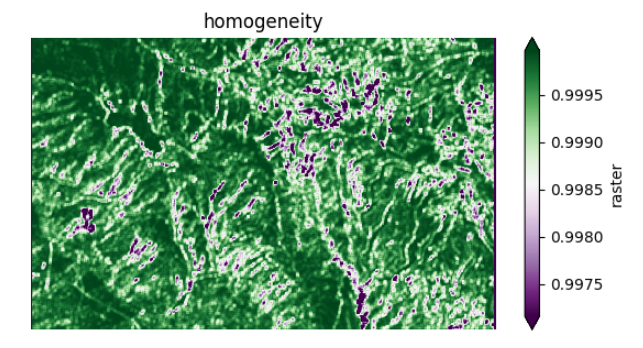

#### GLCMs are often used in computer vision to quantify neighboring pixel relationships (metrics) within a image. While often used across an entire image, GLCMs metrics can be useful if calculated for subregions of an image or even within a moving window context. However, current approaches that use a co-occurrence probability matrix to process GLCM metrics are slow. Our new and novel approach remove this unnecessary step and quantifies GLCM metric values using an optimized, one pass technique. Using this technique, we demonstrate how to implement GLCMs within Raster Tools processing architecture. In this notebook the following metrics are calculated for a portion of Landsat 8 scene located in southern Montana USA:
- contrast
- dissimilarity
- homogeneity
- ASM
- energy
- correlation
- mean
- variance
- std
- entropy   

## Install necessary packages to run on Colab

In [ ]:
!pip install mapclassify
!pip install osmnx
!pip install raster_tools
!pip install planetary-computer
!pip install pystac-client
!pip install stackstac
!pip install distributed -update
!pip install rapids -update


## Import packages

In [ ]:
import numpy as np, os, geopandas as gpd, numba as nb, osmnx as ox, pystac_client, planetary_computer, stackstac
from raster_tools import raster, Raster, general

### The study area
#### Get the boundary data for portions of the Custer Gallatin National Forest and create a interactive location map of the study (Figure 1).

In [ ]:
import folium
#use OpenStreetMaps to get the boundary of the NF
nf=ox.geocode_to_gdf('Custer Gallatin National Forest, MT, USA')

#get first polygon of the NF
nfe=nf.explode()
nf1=gpd.GeoSeries(nfe.geometry.iloc[10],crs=nf.crs)

#project to Albers equal area
nf1p=nf1.to_crs(5070)

#Visualize the nf1 and sample locations
m=nf1p.explore(color='red',style_kwds=dict(fill=False,weight=5),name='Boundary')
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    name="Esri Imagery",
    overlay=False,
    control=True,
).add_to(m)
folium.LayerControl().add_to(m)
m

__Figure 1.__ Interactive location map of the study area.

### Step 1: Get Landsat 8 Imagery
Create download definitions

In [ ]:
#create definition to mosaic stac data
def mosaic_stac(xr):
    return stackstac.mosaic(xr)

#create definition to extract stac data
def get_stac_data(geo,url="https://planetarycomputer.microsoft.com/api/stac/v1",name="sentinel-2-l2a",res=30,crs=5070,**kwarg):
    '''
    gets tiled data from planetary computer as a dask backed xarray that intersects the geometry of the point, line, or polygon

    geo = (polygon) geometry bounding box (WGS84)
    url = (string) base url to planetary computer https://planetarycomputer.microsoft.com/api/stac/v1
    name = (string) catelog resource
    qry =  (dictoinary) of property values {'eo:cloud_cover':{'lt':1}}
    res = (tuple of numbers) output resolution (x,y)
    crs = (int) output crs
    dt = (string) data time intervale e.g., one month: 2023-06, range: 2023-06-02/2023-06-17
    limit = (int) max number of items to return

    returns (xarray data array and stac item catalog)
    '''
    catalog = pystac_client.Client.open(url, modifier=planetary_computer.sign_inplace)
    srch = catalog.search(collections=name, intersects=geo, **kwarg)
    ic = srch.item_collection()
    if(len(ic.items)>0):
        xra = stackstac.stack(ic,resolution=res,epsg=crs)
        xra = mosaic_stac(xra)
    else:
        xra=None

    return xra,ic


Download the data and create a raster object

In [ ]:
#get stac data landsat data
if(not os.path.exists('ls82016.tif')):
    xmin,ymin,xmax,ymax=nf1p.buffer(200).total_bounds
    ls30, ic =get_stac_data(nf1.geometry[0],"https://planetarycomputer.microsoft.com/api/stac/v1",name="landsat-c2-l2",res=30,crs=5070,datetime='2016-06-15/2016-06-30',query={'eo:cloud_cover':{'lt':10},'platform':{'eq':'landsat-8'}},limit=1000)
    ls30s=Raster(ls30.sel(band=['red', 'green', 'blue','nir08', 'lwir11','swir16', 'swir22'],x=slice(xmin,xmax),y=slice(ymax,ymin)))
    ls30s=ls30s.save('ls82016.tif')

ls30s=Raster('ls82016.tif')

Visualize the study area and the Landsat 8 image (Figure 2).

In [ ]:
p=nf1p.plot(edgecolor='red',facecolor='none',figsize=(15,10),linewidth=5)
p=ls30s.get_bands([1,2,3]).xdata.plot.imshow(ax=p,robust=True)


__Figure 2.__ Overlay of Landsat 8 image subset (RGB bands) and the study area boundary outline in red.

### Step 2. Create GLCMs
#### Create definitions to create GLCM Raster datasets.
These GLCM functions do not require setting levels or building a probability matrix. If you want to use levels, you can change the data type of the input raster to the desired bit depth or rescale the raster to the level desired.

In [ ]:
#GLCM
@nb.jit(nopython=True, nogil=True)
def _get_vl(img,glcm,rstart,rws,cstart,clms,roff,coff,n,levels):
    ovl=0
    if(glcm=='contrast'):
        ovl=_get_contrast(img,rstart,rws,cstart,clms,roff,coff,n)
    elif(glcm=='dissimilarity'):
        ovl=_get_dissimilarity(img,rstart,rws,cstart,clms,roff,coff,n)
    elif(glcm=='homogeneity'):
        ovl=_get_homogeneity(img,rstart,rws,cstart,clms,roff,coff,n)
    elif(glcm=='ASM'):
        ovl=_get_asm(img,rstart,rws,cstart,clms,roff,coff,n,levels)
    elif(glcm=='energy'):
        ovl=_get_energy(img,rstart,rws,cstart,clms,roff,coff,n,levels)
    elif(glcm=='entropy'):
        ovl=_get_entropy(img,rstart,rws,cstart,clms,roff,coff,n,levels)
    elif(glcm=='correlation'):
        ovl=_get_correlation(img,rstart,rws,cstart,clms,roff,coff,n)
    elif(glcm=='variance'):
        ovl=_get_variance(img,rstart,rws,cstart,clms,roff,coff,n)
    elif(glcm=='std'):
        ovl=_get_std(img,rstart,rws,cstart,clms,roff,coff,n)
    else:
        ovl=_get_mean(img,rstart,rws,cstart,clms,roff,coff,n)
    return ovl

@nb.jit(nopython=True, nogil=True)
def _get_contrast(img,rstart,rws,cstart,clms,roff,coff,n):
    s=0
    for r in range(rstart,rws):
        for c in range(cstart,clms):
            v1=img[r,c]
            v2=img[r+roff,c+coff]
            dif=v1-v2
            vl= dif*dif*2
            s+=vl
    return s/n

@nb.jit(nopython=True, nogil=True)
def _get_mean(img,rstart,rws,cstart,clms,roff,coff,n):
    s=0
    for r in range(rstart,rws):
        for c in range(cstart,clms):
            v1=img[r,c]
            v2=img[r+roff,c+coff]
            vl=v1+v2
            s+=vl
    return s/n

@nb.jit(nopython=True, nogil=True)
def _get_dissimilarity(img,rstart,rws,cstart,clms,roff,coff,n):
    s=0
    for r in range(rstart,rws):
        for c in range(cstart,clms):
            v1=img[r,c]
            v2=img[r+roff,c+coff]
            vl=np.abs(v1-v2)*2
            s+=vl
    return s/n

@nb.jit(nopython=True, nogil=True)
def _get_homogeneity(img,rstart,rws,cstart,clms,roff,coff,n):
    s=0
    for r in range(rstart,rws):
        for c in range(cstart,clms):
            v1=img[r,c]
            v2=img[r+roff,c+coff]
            dif=v1-v2
            vl= 2/(1+(dif*dif))
            s+=vl
    return s/n

@nb.jit(nopython=True, nogil=True)
def _get_array(img,rstart,rws,cstart,clms,roff,coff,levels):
    #dic={}
    p_arr=np.zeros((levels,levels))
    for r in range(rstart,rws):
        for c in range(cstart,clms):
            v1=int(img[r,c])
            v2=int(img[r+roff,c+coff])
            p_arr[v1,v2]+=1
            p_arr[v2,v1]+=1

    return p_arr

@nb.jit(nopython=True, nogil=True)
def _get_entropy(img,rstart,rws,cstart,clms,roff,coff,n,levels):
    p = _get_array(img,rstart,rws,cstart,clms,roff,coff,levels)
    rws2,clms2=p.shape
    s=0
    for r in range(rws2):
        for c in range(clms2):
            v=p[r,c]
            vl=v/n+0.00000000001
            s+=-1*vl*np.log(vl)

    return s

@nb.jit(nopython=True, nogil=True)
def _get_asm(img,rstart,rws,cstart,clms,roff,coff,n,levels):
    p = _get_array(img,rstart,rws,cstart,clms,roff,coff,levels)
    rws2,clms2=p.shape
    s=0
    for r in range(rws2):
        for c in range(clms2):
            v=p[r,c]
            vl=v/n
            s+=vl*vl

    return s

@nb.jit(nopython=True, nogil=True)
def _get_energy(img,rstart,rws,cstart,clms,roff,coff,n,levels):
    return _get_asm(img,rstart,rws,cstart,clms,roff,coff,n,levels)**0.5

@nb.jit(nopython=True, nogil=True)
def _get_variance(img,rstart,rws,cstart,clms,roff,coff,n):
    s=0
    s2=0
    for r in range(rstart,rws):
        for c in range(cstart,clms):
            v1=img[r,c]
            v2=img[r+roff,c+coff]
            s+=v1+v2
            s2+=v1**2+v2**2
    return (s2-((s**2)/n))/n

@nb.jit(nopython=True, nogil=True)
def _get_std(img,rstart,rws,cstart,clms,roff,coff,n):
    return _get_variance(img,rstart,rws,cstart,clms,roff,coff,n)**0.5

@nb.jit(nopython=True, nogil=True)
def _get_correlation(img,rstart,rws,cstart,clms,roff,coff,n):
    sxy=0
    sx=0
    sx2=0

    for r in range(rstart,rws):
        for c in range(cstart,clms):
            v1=img[r,c]
            v2=img[r+roff,c+coff]
            sx+=v1+v2
            sx2+=v1**2+v2**2
            sxy+=v1*v2


    num=n*sxy*2-sx*sx
    den=((n*sx2-sx**2)*(n*sx2-sx**2))**0.5

    return num/den


@nb.jit(nopython=True, nogil=True)
def _get_n(rws,clms,dist,dir):
    n=1
    if(dir==0):
        n=(rws-dist)*2*clms
    elif(dir==2):
        n=2*rws*(clms-dist)
    else:
        n=(rws-dist)*(clms-dist)*2
    return n

@nb.jit(nopython=True, nogil=True)
def _get_glcm(img,glcms,dists,dirs,levels):
    out_arr=np.zeros((len(glcms),len(dists),len(dirs)))
    gcnt=0
    for glcm in glcms:
        dcnt=0
        for dist in dists:
            drcnt=0
            for dir in dirs:
                rws,clms=img.shape
                n=_get_n(rws,clms,dist=dist,dir=dir)
                # s=0
                coff=0
                roff=0
                rstart=0
                cstart=0
                if(dir==0):
                    coff=dist
                    clms=clms-coff
                elif(dir==1):
                    coff=dist
                    roff=dist
                    clms=clms-coff
                    rws=rws-roff
                elif(dir==2):
                    roff=dist
                    rws=rws-roff
                else:
                    roff=(dist)
                    coff=(-1*dist)
                    cstart=dist
                    rws=rws-roff
                out_arr[gcnt,dcnt,drcnt]=_get_vl(img,glcm,rstart,rws,cstart,clms,roff,coff,n,levels)
                drcnt+=1
            dcnt+=1
        gcnt+=1
    return out_arr

@nb.jit(nopython=True, nogil=True)
def _glcm(X,glcms,dists,dirs,wsize,levels):
    '''
    Creates GLCM surfaces for a given array. Used with dask's map_overlap function.

    X = (array) numpy array
    glcms = (list of glcm names) ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation', 'mean', 'variance', 'std', 'entropy']
    dists = (list of cell offsets) [1,2,3...]
    dirs = (list of offset directions) [0,1,2,3] 0=horzontal, 1=diagonal 1, 2=vertical, 3=diagonal 2
    wsize = (int) window width
    returns a 3d array with dimensions equal to the length of bnds*glcms*dists*dirs,rows,columns of the original image and parameters
    '''
    bnd,rws,clms=X.shape
    hw=int(wsize/2)
    lg=len(glcms)
    ld=len(dists)
    ldr=len(dirs)
    outarr=np.zeros((bnd*lg*ld*ldr,rws,clms))
    for b in range(bnd):
        bndst=b*lg*ld*ldr
        bndend=bndst+lg*ld*ldr
        for r in range(0,rws-wsize):
            nr=r+hw
            for c in range(0,clms-wsize):
                nc=c+hw
                img= X[b,r:r+wsize,c:c+wsize]
                vls=_get_glcm(img,glcms,dists,dirs,levels)
                outarr[bndst:bndend,nr,nc]=vls.flatten()
    return outarr

def glcm_wd(rs,glcm='contrast',dist=1,dir=0,wsize=3,cat=8):
    '''
    Creates GLCM Raster for a specified GLCM and window size.

    rs = (Raster) input raster
    glcm = (string) glcm names ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation', 'mean', 'variance', 'std', 'entropy']
    dist = (int) cell offsets) 1,2,3, or ...
    dir = (int) offset directions) 0,1,2, or 3 0=horzontal, 1=diagonal 1, 2=vertical, 3=diagonal 2
    wsize = (int) window width
    cat = (int) optional values for ASM, energy, and entropy GLCM. For these GLCM metrics, raster cell values cannot be greater than the number of levels-1

    returns a mutiband Raster with dimensions equal to the length of bnds*glcms*dists*dirs,rows,columns of the original image and parameters
    '''
    hw=int(wsize/2)
    #use map overlap function to retrieve kernel cell values
    darr = rs.data.map_overlap(
        _glcm,
        depth={0: 0, 1: hw, 2: hw},
        trim=True,
        boundary=0,
        dtype='f8',
        meta=np.array((),dtype='f8'),
        glcms=[glcm],
        dists=[dist],
        dirs=[dir],
        wsize=wsize,
        levels=cat,
    )
    out_rs=raster.data_to_raster(darr,mask=rs.mask,x=rs.x,y=rs.y,affine=rs.affine,crs=rs.crs)
    return out_rs


#### Create GLCM surfaces for neighboring pixels (1 pixel distance), in all four directions, within a 3 by 3 window. In total this process will create a 280 GLCM surfaces (7 bands * 10 GLCM metrics * 4 directions).

In [ ]:
wsize=7 #adjust to desired size
glcm_names=['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation', 'mean', 'variance', 'std', 'entropy']
glcm_names2=['contrast', 'dissimilarity', 'homogeneity', 'correlation', 'mean', 'variance', 'std']
rs_lst=[]
for glcm in glcm_names:
    for d in [0,1,2,3]:
        rs_lst.append(glcm_wd(ls30s,glcm,1,d,wsize,256))

glcm_rs=general.band_concat(rs_lst)
glcm_rs.xdata

#### Visualize the GLCMs for the near IR Landsat 8 band (band 4) and direction 0 (horizontal).

In [ ]:
from matplotlib import pyplot

fig, ax=pyplot.subplots(ncols=2,nrows=5,figsize=(15,20))

bnd=4 #select Landsat band
dir=0 #select direction


glcm_b_rs=glcm_rs.get_bands(list(np.arange((bnd-1)+(ls30s.nbands*dir),280,28)+1)) #select GLCMs for IR band

for b in glcm_b_rs.band:
    r=(b-1)//2
    c=(b-1)%2

    p=glcm_b_rs.get_bands(b).plot(robust=True,cmap='PRGn',ax=ax[r,c])
    ax[r,c].title.set_text(glcm_names[b-1])
    ax[r,c].axis('off')

fig.suptitle('GLCMs for Landsat band '+str(bnd) + ', distance = 1, and direction = ' + str(dir),fontsize=25)

#### Adjust window size, band, and direction to view GLCM textures for various parameter setting

### Discussion
This new approach is significantly faster than using a sparse probability matrix to create moving window GLCM surfaces and is faster when calculating GLCM metrics for raster aggregation. Moreover, this approach provides the flexibility to create various GLCM metrics within the Raster Tools processing framework, making it readily available to the geospatial community. Finally, these same functions can be used to create GLCM metrics for the entire image in a fraction of the time required to perform the same analysis using the co-occurrence probability matrix.    

#### Timing to calculate each GLCM metric for the entire image using the new approach described and scikit image.

##### To facilitate processing using skimage we need to convert the input data into positive integer values (uint8). This is only required for the Energy, ASM, and Entropy metric in the newer approach but was used to consistently compare runtimes.

In [ ]:
rs_lst=[]
for b in ls30s.band:
    rs=ls30s.get_bands(b)
    minv=rs.min().compute()
    maxv=rs.max().compute()
    t=(((rs-minv)/(maxv-minv))*254)
    t2=t.set_null_value(255).astype('uint8')
    rs_lst.append(t2)

rs2=general.band_concat(rs_lst)
imgs=rs2.to_numpy()


##### Timing for new procedure
- All GLCMs
- 1 cell away
- Horizontal

In [ ]:
import time, skimage

iter=1000

run_time_d={}

for glcm in glcm_names:
    t1=time.perf_counter()
    for i in range(iter):
        for b in range(imgs.shape[0]):
            img = imgs[b]
            _get_glcm(img,[glcm],[1],[0],256)
    t2=time.perf_counter()
    run_time_d[glcm]=t2-t1

##### Timing for skimage
- All GLCMs
- 1 cell away
- Horizontal

In [ ]:
run_time_d2={}

for glcm in glcm_names:
    t1=time.perf_counter()
    for i in range(iter):
        for b in range(imgs.shape[0]):
            img = imgs[b]
            p=skimage.feature.graycomatrix(img,[1],[0],levels=256,symmetric=True,normed=True)
            skimage.feature.graycoprops(p,glcm)

    t2=time.perf_counter()
    run_time_d2[glcm]=t2-t1


In [ ]:
import pandas as pd
df1=pd.DataFrame.from_dict(run_time_d,orient='index',columns=['newer approach'])
df2=pd.DataFrame.from_dict(run_time_d2,orient='index',columns=['skimage approach'])
df=pd.concat([df1,df2],axis=1)
df.plot.bar(ylabel='Seconds',xlabel='GLCM',title='Processing time of ' + str(iter) + ' iterations',figsize=(12,8))